# Training Data Acquisition and Labeling

In this notebook, we go through the dataset and create .csv labels based on their .midi pitch. After doing that, we feed PyTorch the necessary information about onsets and generate training data on-the-fly.

## Setup

In [26]:
%matplotlib inline

import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import pretty_midi
import numpy as np
import os
import csv

dataset_loc = os.path.join("../groove-v1.0.0", "groove")
drum_floor = 22
drum_ceil = 76

The `drum_floor` and `drum_ceiling` parameters are necessary as many MIDIs have pitches that play way outside of the traditional MIDI drum range (36 and up). That way we can make sure to cutoff any unnecessary data.

## What are MIDI ticks?

Note that the `time` value for events in MIDI files is measured in **delta time MIDI ticks**. 

A tick is the smallest unit of time in MIDIs, and their duration is defined by the `ticks_per_beat` parameter stored in the MIDI file. In our dataset, all files have a fixed `ticks_per_beat` value of `480`, which means every beat lasts 480 ticks. Now, traditionally, a song's beat duration or tempo is defined by BPM, beats per minute. In case of MIDIs however, the `tempo` is measured in microseconds per beat. For example, 100 BPM would equate to 600,000 μSPB. 

To convert $BPM$ to $\mu{SPB}$, we can use the following formula: 

$$ \mu{SPB} = \frac{60}{BPM} \cdot 10^6 $$

The formula for converting ticks to seconds would like something like this: 

$$ t_{sec} = \frac{t_{tick} \cdot \mu{SPB}}{TPB \cdot 10^6} $$

where:

* $t_{sec}$ is the absolute time in seconds
* $t_{tick}$ is the absolute time in ticks
* $TPB$ is the number of ticks per beat specified in the MIDI file
* $\mu SPB$ is the tempo of the MIDI file in microseconds per beat

For convenience, the `mido` package has built-in conversion functions like `bpm2tempo(bpm)`, `tempo2bpm(tempo)` and `tick2second(tick, ticks_per_beat, tempo)`. We will be using the `pretty_midi` package that converts all ticks to seconds for us.

## Getting MIDI onsets

The following function takes a MIDI filename as input and displays a piano-roll of drum instruments. This is just a helper function to visualize MIDIs in testing.

In [21]:
def plot_drum_track(midi_file, drum_program=0):
    # Load MIDI file and select drum track
    midi_data = pretty_midi.PrettyMIDI(midi_file)

    drum_track = midi_data.instruments[0]
    drum_track.is_drum = False
    drum_track.program = drum_program
    unique_pitches = np.unique([x.pitch-drum_floor for x in drum_track.notes if x.pitch >= drum_floor])

    # Set up figure and axes
    fig, ax = plt.subplots(figsize=(12, 4))
    plt.subplots_adjust(bottom=0.2)

    # Plot piano roll and labels for each drum note
    drum_roll = drum_track.get_piano_roll(fs=100)[drum_floor:drum_ceil]
    im = ax.imshow(drum_roll, aspect='auto', origin='lower', cmap='coolwarm')
    ax.set_yticks(unique_pitches)
    ax.set_yticklabels([pretty_midi.note_number_to_drum_name(x+drum_floor) for x in ax.get_yticks()])
    ax.set_ylabel('Drum')
    ax.set_xlabel('Time (10ms)')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Intensity', rotation=270, labelpad=15)

    plt.show()

The `extract_drums` function iterates over each MIDI instrument in the parsed data, and if an instrument is found to be a drum instrument, the function returns that instrument. It also cuts out any pitches outside of the `drum_floor` - `drum_ceiling` range.

The `instrument_to_csv` takes that instrument and writes it to a .csv file, which is what we are going to be using to convert MIDIs to .csv.

In [22]:
drum_mapping={
          36: "kick",

          38: "snare",
          40: "snare_rimshot",
          37: "snare_xstick",

          48: "tom1",
          50: "tom1_rim",
          45: "tom2",
          47: "tom2_rim",
          43: "tom3",
          58: "tom3_rim",

          46: "hhopen_bow",
          26: "hhopen_edge",
          42: "hhclosed_bow",
          22: "hhclosed_edge",
          44: "hhpedal",
          
          49: "crash1_bow",
          55: "crash1_edge",
          57: "crash2_bow",
          52: "crash2_edge",
          51: "ride_bow",
          59: "ride_edge",
          53: "ride_bell",
          
          39: "clap",
          54: "tambourine",
          56: "cowbell"
}

In [9]:
def extract_drums(path):
    midi_data = pretty_midi.PrettyMIDI(path)
    for instr in midi_data.instruments:
        if instr.is_drum:
            # we make sure to cutoff any unnecessary frequencies
            instr.notes = [x for x in instr.notes if drum_floor <= x.pitch <= drum_ceil]
            return instr
    return None

def instrument_to_csv(instrument, csv_filename, length, threshold=0.02):
    with open(csv_filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pitches', 'velocities', 'start_time', 'end_time'])
        
        notes = sorted(instrument.notes, key=lambda note: note.start)  # sort notes by start time
        notes = [note for note in notes if note.start < length]

        # group nearby notes together based on threshold
        groups = []
        current_group = [notes[0]]
        for i in range(1, len(notes)):
            if notes[i].start - current_group[0].start < threshold:
                current_group.append(notes[i])
            else:
                groups.append(current_group)
                current_group = [notes[i]]
        groups.append(current_group)
        
        # write each group to CSV
        for group in groups:
            pitches = " ".join([str(note.pitch) for note in group])
            velocities = " ".join([str(note.velocity) for note in group])
            start_time = group[0].start
            end_time = group[-1].end
            csvwriter.writerow([pitches, velocities, start_time, end_time])

def midi_to_csv(midi_path, csv_path, length):
    instrument_to_csv(extract_drums(midi_path), csv_path, length)

We can also write a helper function that uses FluidSynth to synthesize midis, which I will use to generate extra training data.

In [14]:
def synthesize_mid(midi_path):
    instr = extract_drums(midi_path)
    return Audio(instr.fluidsynth(44100, "JV_1080_Drums.sf2"), rate=44100)

## MIDI to CSV

Now, let us load the dataset to label every audio file's instance of a drum note.

In [27]:
df = pd.read_csv(os.path.join(dataset_loc, "info.csv"))
df

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test
...,...,...,...,...,...,...,...,...,...,...,...
1145,drummer2,drummer2/session2,drummer2/session2/11,rock,130,beat,4-4,drummer2/session2/11_rock_130_beat_4-4.mid,NaN,1.909613,train
1146,drummer2,drummer2/session2,drummer2/session2/12,rock,130,beat,4-4,drummer2/session2/12_rock_130_beat_4-4.mid,NaN,1.808652,train
1147,drummer2,drummer2/session2,drummer2/session2/13,rock,130,beat,4-4,drummer2/session2/13_rock_130_beat_4-4.mid,NaN,1.864421,train
1148,drummer2,drummer2/session2,drummer2/session2/14,rock,130,beat,4-4,drummer2/session2/14_rock_130_beat_4-4.mid,NaN,1.875960,train


Let's create a new column in our dataframe to hold the .csv filename:

In [34]:
df['csv_filename'] = df['midi_filename'].str.replace(".mid", ".csv", regex=False)
df

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split,csv_filename
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test,drummer1/eval_session/1_funk-groove1_138_beat_...
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test,drummer1/eval_session/10_soul-groove10_102_bea...
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test,drummer1/eval_session/2_funk-groove2_105_beat_...
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test,drummer1/eval_session/3_soul-groove3_86_beat_4...
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test,drummer1/eval_session/4_soul-groove4_80_beat_4...
...,...,...,...,...,...,...,...,...,...,...,...,...
1145,drummer2,drummer2/session2,drummer2/session2/11,rock,130,beat,4-4,drummer2/session2/11_rock_130_beat_4-4.mid,NaN,1.909613,train,drummer2/session2/11_rock_130_beat_4-4.csv
1146,drummer2,drummer2/session2,drummer2/session2/12,rock,130,beat,4-4,drummer2/session2/12_rock_130_beat_4-4.mid,NaN,1.808652,train,drummer2/session2/12_rock_130_beat_4-4.csv
1147,drummer2,drummer2/session2,drummer2/session2/13,rock,130,beat,4-4,drummer2/session2/13_rock_130_beat_4-4.mid,NaN,1.864421,train,drummer2/session2/13_rock_130_beat_4-4.csv
1148,drummer2,drummer2/session2,drummer2/session2/14,rock,130,beat,4-4,drummer2/session2/14_rock_130_beat_4-4.mid,NaN,1.875960,train,drummer2/session2/14_rock_130_beat_4-4.csv


In [35]:
df.to_csv(os.path.join(dataset_loc, "info.csv"))

With that, we can now generate .csv files for every MIDI file in the dataset.

In [30]:
df.apply(lambda x: midi_to_csv(os.path.join(dataset_loc, x['midi_filename']), os.path.join(dataset_loc, x['csv_filename']), x['duration']), axis=1)

# check if csv files are created
for csv_file in df['csv_filename']:
    if not os.path.exists(dataset_loc+csv_file):
        print(f"{csv_file} does not exist.")

drummer1/eval_session/1_funk-groove1_138_beat_4-4.csv does not exist.
drummer1/eval_session/10_soul-groove10_102_beat_4-4.csv does not exist.
drummer1/eval_session/2_funk-groove2_105_beat_4-4.csv does not exist.
drummer1/eval_session/3_soul-groove3_86_beat_4-4.csv does not exist.
drummer1/eval_session/4_soul-groove4_80_beat_4-4.csv does not exist.
drummer1/eval_session/5_funk-groove5_84_beat_4-4.csv does not exist.
drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.csv does not exist.
drummer1/eval_session/7_pop-groove7_138_beat_4-4.csv does not exist.
drummer1/eval_session/8_rock-groove8_65_beat_4-4.csv does not exist.
drummer1/eval_session/9_soul-groove9_105_beat_4-4.csv does not exist.
drummer1/session1/1_funk_80_beat_4-4.csv does not exist.
drummer1/session1/10_jazz-funk_116_fill_4-4.csv does not exist.
drummer1/session1/100_neworleans-secondline_94_beat_4-4.csv does not exist.
drummer1/session1/101_dance-disco_120_beat_4-4.csv does not exist.
drummer1/session1/102_funk_95_beat_4-4

Sample .csv file:

In [31]:
df_sample = pd.read_csv(os.path.join(dataset_loc, "drummer1/session2/1_latin-chacarera_157_beat_3-4.csv"))
df_sample

,pitches,velocities,start_time,end_time
0,37,80,0.000000,0.097930
1,44 37,65 85,0.366242,0.473727
2,40,91,0.562899,0.664013
3,44,67,0.738058,0.838377
4,50,93,0.765924,0.867039
...,...,...,...,...
888,42 45,70 73,147.300311,147.408592
889,42,64,147.480248,147.581363
890,43,73,147.568624,147.669739
891,42,103,147.662573,147.762892


We can now see just how many snippets we got:

In [33]:
dfs = []
for idx, row in df.iterrows():
    temp_df = pd.read_csv(os.path.join(dataset_loc,row['csv_filename']))
    temp_df['id'] = row['id']  # add id as a new column
    dfs.append(temp_df)

final_df = pd.concat(dfs, ignore_index=True)
instrument_type_counts = final_df['instrument_type'].value_counts()

KeyError: 'instrument_type'

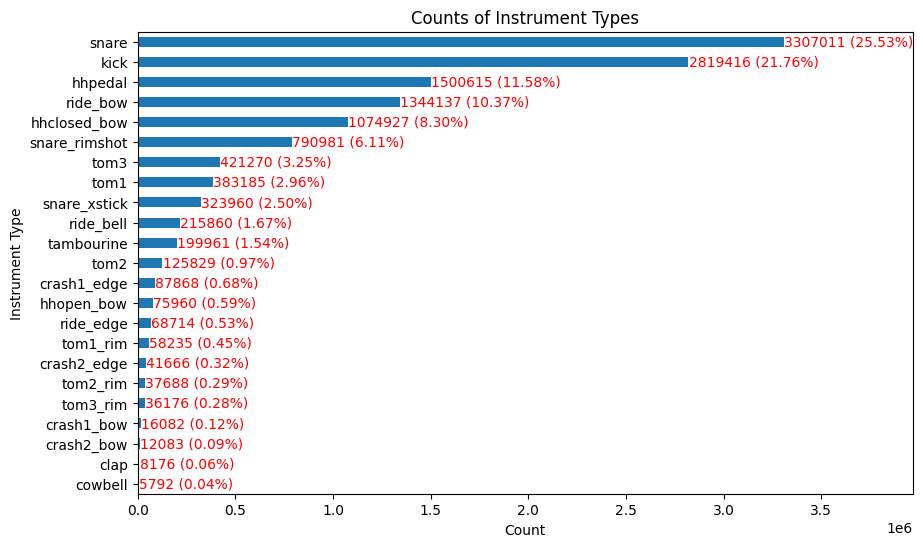

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
instrument_type_counts.plot(kind='barh', ax=ax)
for i, v in enumerate(instrument_type_counts):
    label = f'{v} ({v/sum(instrument_type_counts)*100:.2f}%)'
    ax.text(v+1000, i, label, color='red', va='center')
ax.invert_yaxis()
ax.set_xlim([0, max(instrument_type_counts) * 1.2])
plt.ylabel('Instrument Type')
plt.xlabel('Count')
plt.title('Counts of Instrument Types')
plt.show()

Based on the frequency distribution chart of the classes in the drum dataset, we can assert that the majority of classes consist of bass and snare drums, followed by hats & rides, toms, and then cymbals. This is logical because bass and snare drums are essential for creating rhythm and are used more frequently than other types of drums. On the flip side, crash cymbals are often used to transition between sections and are not used as frequently for rhythm. Therefore, there is an inherent disparity in the frequency of usage among the different drum types, solely based on the natural way drums are played.

As it stands, we have created an ***insanely*** unbalanced dataset. The crash cymbals are in the thousands, while the snares are 50x as prevalent. We need a way to deal with this natural class imbalance, as it will hinder the model's ability to identify the minority classes with a bias towards the majority classes.

There are several ways to combat this class imbalance:

1. **Data augmentation:** This involves creating new examples of the minority class by applying various transformations to the existing examples. For example, we can use pitch shifting, time stretching, or other audio effects to create new versions of the crash cymbal sounds. This can help increase the amount of data available for the minority class and improve the model's ability to recognize it.

2. **Upsampling:** Upsampling involves duplicating examples of the minority class to increase their representation in the dataset. This can be done randomly, or using more sophisticated techniques like SMOTE (Synthetic Minority Over-sampling Technique), which generates new synthetic examples of the minority class by interpolating between existing examples.

3. **Downsampling:** Downsampling involves reducing the number of examples of the majority class to match the number of examples of the minority class. This can be done randomly, or using more sophisticated techniques like Tomek links, which remove examples from the majority class that are close to examples from the minority class.

4. **Weighted loss functions:** We can use a weighted loss function that gives more importance to the minority class during training. This can help the model learn to focus on the minority class and improve its ability to recognize it.

5. **Ensemble models:** An ensemble model combines multiple models to improve performance. We can train several models on different subsets of the data, with each subset having an equal number of examples from each class. The models can then be combined to create a final prediction.

6. **Genre variation:** Another thing we can do is introduce more varied genres of play. Punk-rock music often utilizes the crash cymbal for rhythm purposes, and as such, can be used to introduce thousands of crash cymbals into the dataset. As it stands, the database seems heavily biased towards rock, whereas my goal is to create a tool for starter drummers, where punk-rock is a cornerstone of learning.